This analysis will focus on the "Politics" and "Conservative" subreddits. These subreddits both cover U.S. politics but from vastly different perspectives, citing (usually) different news sources. Each subreddit is comprised exclusively of links to news articles in which the title of the post is the verbatim title of the article that is being linked. While the two subreddits will generally contain stories on the same topics topics, the news sources tend to have very different perspectives on current events. We will check to see if this is reflected in the titles of the articles.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import time
import requests

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier, RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.feature_extraction import text
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from nltk.corpus import stopwords
from nltk import download
import re

The information contained in these subreddits is largely contained within the "title"
of the post as opposed to the body. 

Because of this, we will take the function used in
 the project 3 demo and change full = full.loc[full['is_self'] == True] to False. 
 
 This will allow us to return the posts with actual useful information. In the "Politics" and
 "Conservative" subreddits, it is actually part of the subreddit rules for posts to be 
 titled based on the exact name of an article's link.

In [4]:
def query_pushshift(subreddit, kind = 'submission', day_window = 1, n = 200):
    SUBFIELDS = ['title', 'selftext', 'subreddit', 'created_utc', 'author', 'num_comments', 'score', 'is_self']
    
    BASE_URL = f"https://api.pushshift.io/reddit/search/{kind}"
    stem = f"{BASE_URL}?subreddit={subreddit}&size=500"
    
    posts = []
    
    print('Loading, please wait....')
    for i in range(0, n + 1):
        URL = "{}&after={}d".format(stem, day_window * i)
        response = requests.get(URL)
        assert response.status_code == 200
        mine = response.json()['data']
        df = pd.DataFrame.from_dict(mine)
        posts.append(df)
        time.sleep(2)
    
    full = pd.concat(posts, sort=False)
    
    if kind == "submission":
        full = full[SUBFIELDS]
        full.drop_duplicates(inplace = True)
        full = full.loc[full['is_self'] == False]

    full['timestamp'] = full["created_utc"].map(dt.date.fromtimestamp)
    
    print("Query Complete!")    
    return full.reset_index(drop = True)

In [5]:
# Running the function on the "Politics" subreddit and saving the results as a dataframe.

# pol = query_pushshift(subreddit = 'politics')

In [6]:
# Doing the same thing for the Conservative subreddit. Will check to see if there are less
# observations (the politics subreddit is significantly more popular than the Conservative
# subreddit.)

# con = query_pushshift(subreddit = 'conservative')

In [7]:
# We will save these dataframes as csv's so we don't have to rerun the API query every 
# time the project is re-opened.

# pol.to_csv('./data/politics.csv', index = False)
# con.to_csv('./data/conservative.csv', index = False)

In [8]:
# For future usage, we will now read in the csv's we have just created.
pol = pd.read_csv('./data/politics.csv')
con = pd.read_csv('./data/conservative.csv')

In [9]:
# Surprisingly, the datasets are fairly similar in size. We can still ensure classes aren't
# imbalanced when putting the dataframes together, but I had expected the politics
# subreddit to contain more observations than the conservative subreddit.
pol.shape, con.shape

((19807, 9), (16164, 9))

DATA PREPARATION

In [10]:
# The null values make sense, as it is against the subreddit's rules to include text
# within the body of the post. We can simply remove this column from both dataframes.

pol.isnull().sum()

title               0
selftext        19111
subreddit           0
created_utc         0
author              0
num_comments        0
score               0
is_self             0
timestamp           0
dtype: int64

In [11]:
con.isnull().sum()

title               0
selftext        15858
subreddit           0
created_utc         0
author              0
num_comments        0
score               0
is_self             0
timestamp           0
dtype: int64

In [15]:
# Dropping the Unnamed: 0 column from both dataframes, along with the is_self column and
# created_utc columns since we know that is_self is false and the created_utc will not
# be used.

pol.drop(columns = ['Unnamed: 0', 'selftext','is_self','created_utc'], inplace = True)
con.drop(columns = ['Unnamed: 0', 'selftext','is_self','created_utc'], inplace = True)

In [13]:
pol.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Lawmakers to grill Biden's pick for UN ambassa...,NaN,politics,1611759471,MabintyQ,2,1,False,2021-01-27
1,What Does R/politics think about US healthcare?,NaN,politics,1611759657,RolledCTY,0,1,False,2021-01-27
2,Josh Hawley calls out ‘muzzling of America’ in...,NaN,politics,1611759783,76patrioto,2,1,False,2021-01-27
3,I have election protesters and 'Never Trumpers...,NaN,politics,1611759828,PoliticiansAlwaysLie,73,1,False,2021-01-27
4,Sen. Patrick Leahy taken to hospital,NaN,politics,1611759867,Marshall221,6,1,False,2021-01-27


In [14]:
con.head()

,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,Stephen Crowder hits it on the head in his new...,NaN,Conservative,1611759411,that_was_rhetorical,0,1,False,2021-01-27
1,Deroy Murdock: Trump answered liberal prayers ...,NaN,Conservative,1611759478,nimobo,2,1,False,2021-01-27
2,Former Ohio Health Department Director Amy Act...,NaN,Conservative,1611759954,DerKompassar,0,1,False,2021-01-27
3,The Twitter Censorship Will Be an Unending Ass...,NaN,Conservative,1611759972,GenZConservative1776,0,1,False,2021-01-27
4,‘I’ll Give You A Word: Money’: Biden Chief Of ...,NaN,Conservative,1611760322,Winterhold2000,1,1,False,2021-01-27


In [16]:
# Consolidating both dataframes into one
df = pd.concat([pol, con])
df.reset_index(inplace = True)

In [17]:
# Mapping the new dataframe to make "politics" subreddit will be made into a 1 and 
# "Conservative" will be made into a 0.
subreddit = df['subreddit']
df['subreddit'] = df['subreddit'].map(lambda x: 1 if x == 'politics' else 0)

In [18]:
df['word_count'] = df['title'].str.split().str.len()

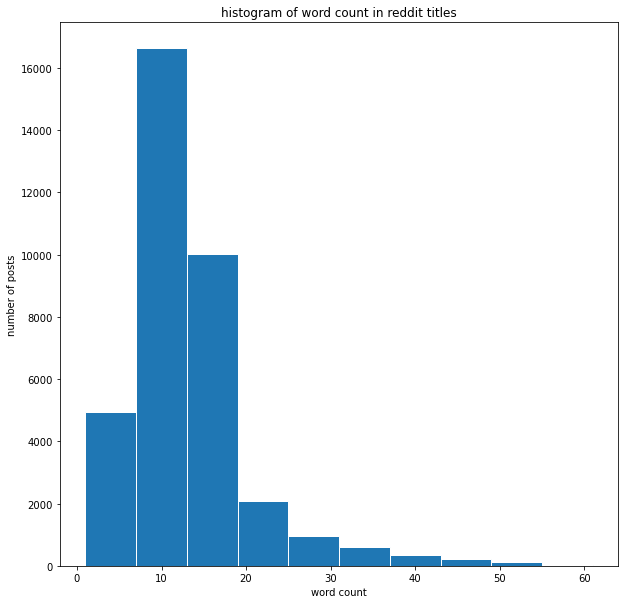

In [19]:
plt.figure(figsize = (10,10))
plt.title('histogram of word count in reddit titles')
plt.xlabel('word count')
plt.ylabel('number of posts')
plt.hist(df['word_count'], ec = 'white');

This bar chart illustrates one interesting (and potentially problematic) characteristic of this data set. The vast majority of posts only have a length of 5-20 words, meaning there might be less overall data and useful information than other subreddits which might have paragraphs-long text posts.

In [20]:
# Saving the dataframe as a csv for future use.
# df.to_csv('./data/polcon.csv')

In [21]:
df = pd.read_csv('./data/polcon.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.drop(columns = 'index', inplace = True)

In [22]:
df.head()

,title,subreddit,author,num_comments,score,timestamp,word_count
0,Lawmakers to grill Biden's pick for UN ambassa...,1,MabintyQ,2,1,2021-01-27,13
1,What Does R/politics think about US healthcare?,1,RolledCTY,0,1,2021-01-27,7
2,Josh Hawley calls out ‘muzzling of America’ in...,1,76patrioto,2,1,2021-01-27,12
3,I have election protesters and 'Never Trumpers...,1,PoliticiansAlwaysLie,73,1,2021-01-27,16
4,Sen. Patrick Leahy taken to hospital,1,Marshall221,6,1,2021-01-27,6


I tried lemmatizing this data, but did not see any significant change in my scores. Because of this, I've decided to keep all words and characters in the posts, especially since I am hopeful to get as much useful data out of these subreddit titles as possible.

SOME EDA AND PREP FOR MODELING

In [20]:
X = df['title']
y = df['subreddit']

In addition to english stop-words, I will be including a small collection of words that are ubiquitous in nearly every post on each subreddit. In a scrap notebook, I saw that the top 10-15 words between the two subreddits are identical, so including those words won't improve predictive capability. 


In [21]:
custom = ['trump','biden','election','covid','president','joe','donald','house','gop',
         'says','senate','capitol','new','campaign','subreddit_y']
combined_words = text.ENGLISH_STOP_WORDS.union(custom)
cvec = CountVectorizer(stop_words = combined_words)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 28, stratify = y)

In [23]:
Xc_train = cvec.fit_transform(X_train)
Xc_test = cvec.transform(X_test)

In [24]:
X_df = pd.DataFrame(Xc_train.todense(),
                    columns=cvec.get_feature_names())

In [25]:
X_df.sum().sort_values(ascending = False)[:15]

white          817
19             736
coronavirus    709
people         688
democrats      658
police         657
2020           648
news           644
black          613
court          584
georgia        541
just           524
vote           521
america        492
china          458
dtype: int64

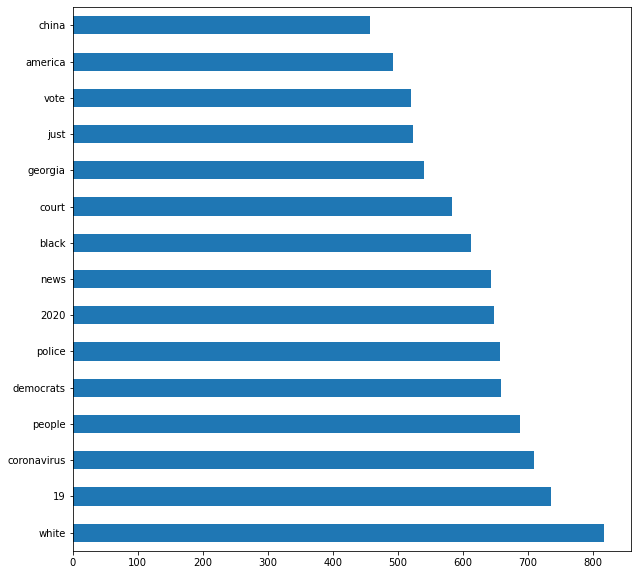

In [26]:
# Plotting the top 15 most common words in a bar chart
plt.figure(figsize = (10,10))
X_df.sum().sort_values(ascending = False).head(15).plot(kind = 'barh');

This bar chart shows the top 15 most common words across the entire dataset (after removal of stop words). I am interested to see if these words (possibly when incorporating bigrams) are useful in this analysis. Intuitively, I can guess how many of these words could be used in very different contexts.

MODELING

Initializing TfidfVectorizer to vectorize our X_train and X_test. We will use these 
throughout the analysis, as TfidfVectorizer should do slightly better when there is such significant overlap between the two subreddits and will weight unique words more heavily.

In [30]:
tvec = TfidfVectorizer(stop_words = combined_words)
Xt_train = tvec.fit_transform(X_train)
Xt_test = tvec.transform(X_test)

1. Baseline Score

In [31]:
y.value_counts(normalize = True)

1    0.550638
0    0.449362
Name: subreddit, dtype: float64

55.1% of posts come from the "Politics" subreddit. The null model (a model which always predicts that a post came from the "Politics" subreddit) would be 55.1% accurate, so this is what we hope to beat with our modeling. I am actually not expecting to achieve extraordinarily high accuracy with any model, as there will still be significant overlap between the most common words of the subreddit titles, even with some of the most common words (like "Trump", "Biden", and "election") removed from the models.

2. Logistic Regression

First, we will just fit a default logistic regression and see how well this simple model can beat the null model.

In [32]:
logreg = LogisticRegression(solver = 'liblinear')

In [33]:
param_grid_logreg = [{'penalty' : ['l1','l2']}]

In [34]:
logreg_gridsearch = GridSearchCV(logreg,
                                param_grid_logreg,
                                cv = 5,
                                verbose = 1)

In [35]:
logreg_gridsearch.fit(Xt_train, y_train);

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


In [36]:
logreg_gridsearch.score(Xt_train, y_train), logreg_gridsearch.score(Xt_test, y_test)

(0.8066572762992068, 0.6846436116979874)

In [37]:
logreg_gridsearch.best_params_

{'penalty': 'l2'}

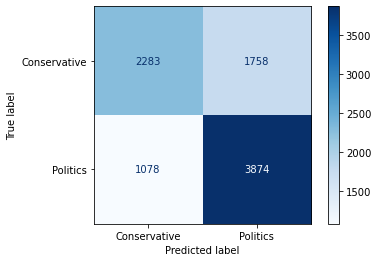

In [168]:
logreg_preds = logreg_gridsearch.predict(Xt_test)
plot_confusion_matrix(logreg_gridsearch, Xt_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['Conservative', 'Politics']);

tn, fp, fn, tp = confusion_matrix(y_test, logreg_preds).ravel()

In [169]:
spec = tn / (tn + fp)
spec

0.5649591685226429

Our first model, the completely-default logistic regression, provided a pretty substantial increase in accuracy (more than I had anticipated). The model correctly predicted 68.5% of the test data, but the model is pretty significantly overfit. While more accurate than the null model, the logistic regression had a poor specificity (.56) meaning it struggled to correctly predict true negatives.

3. KNN

Now we will fit a kNN model through gridsearch to optimize parameters. From the outset, I have very low expectations for kNN on this dataset.

In [38]:
knn = KNeighborsClassifier()

# Data must be standardized for kNN
ss = StandardScaler(with_mean = False)

# Scaling Xt_train and Xt_test
Xs_train_knn = ss.fit_transform(Xt_train)
Xs_test_knn = ss.transform(Xt_test)

In [39]:
# Setting up a dictionary of parameters to test in a gridsearch
knn_params = {
    'n_neighbors' : [3,5,7,9,11],
    'metric' : ['euclidean','manhattan','minkowski'],
    'weights' : ['uniform','distance']
}

In [40]:
knn_gridsearch = GridSearchCV(knn,
                             knn_params,
                             cv = 5,
                             verbose = 1)

In [54]:
knn_gridsearch.fit(Xs_train_knn, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  5.4min finished


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 7, 9, 11],
                         'weights': ['uniform', 'distance']},
             verbose=1)

In [55]:
print(f'Best score: {knn_gridsearch.best_score_}')
print(f'Best estimator: {knn_gridsearch.best_estimator_}')
print(f'Best parameters: {knn_gridsearch.best_params_}')

Best score: 0.548668563745774
Best estimator: KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')
Best parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


In [56]:
# Manually checking the best parameters from the gridsearch
knn_best = KNeighborsClassifier(n_neighbors = 5,
                               weights = 'distance',
                               metric = 'euclidean')

In [57]:
knn_best.fit(Xs_train_knn, y_train)

KNeighborsClassifier(metric='euclidean', weights='distance')

In [58]:
knn_best.score(Xs_train_knn, y_train), knn_best.score(Xs_test_knn, y_test)

(0.9881014159685669, 0.5770043367063271)

In [159]:
knn_preds = knn_best.predict(Xs_test_knn)

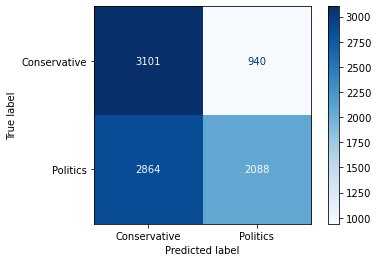

In [165]:
plot_confusion_matrix(knn_best, Xs_test_knn, y_test, cmap='Blues', 
                      values_format='d', display_labels=['Conservative', 'Politics']);

tn, fp, fn, tp = confusion_matrix(y_test, knn_preds).ravel()

In [167]:
# Checking the sensitivity

recall = recall_score(y_test, knn_preds)
recall

0.42164781906300486

Even with the best parameters (which I double-checked by fitting a new model), kNN only achieves a test score of 57.7%, suggesting that this is only negligibly better than the null model. kNN did not succeed at all, which could likely be explained by the fact that there is so much overlap between the two subdreddits. The confusion matrix shows us that the model had a very poor sensitivity (.42) showing that it's ability to correctly identify true positives was very bad.

4. Decision Tree, Bagging, Random Forest, Extra Trees Predictions

For this step, we will first compare the cross_val_score of Decision Tree, Bagging, Random Forest, and Extra Trees models, then pick the best score to further develop through a gridsearch.

In [42]:
dt = DecisionTreeClassifier(random_state = 28)
bag = BaggingClassifier(random_state = 28)
rf = RandomForestClassifier(random_state = 28)
et = ExtraTreesClassifier(random_state = 28)

In [ ]:
# Commenting out next two cells since they take very long to run.

# print(cross_val_score(dt, Xt_train, y_train, cv = 5).mean())
# print(cross_val_score(bag, Xt_train, y_train, cv = 5).mean())
# print(cross_val_score(rf, Xt_train, y_train, cv = 5).mean())
# print(cross_val_score(et, Xt_train, y_train, cv = 5).mean())

In [ ]:
# print(cross_val_score(dt, Xt_test, y_test, cv = 5).mean())
# print(cross_val_score(bag, Xt_test, y_test, cv = 5).mean())
# print(cross_val_score(rf, Xt_test, y_test, cv = 5).mean())
# print(cross_val_score(et, Xt_test, y_test, cv = 5).mean())

Random Forest provided the best result on the test data (64.8%), so we will do a gridsearch to find the best parameters.

In [83]:
rf = RandomForestClassifier()

In [52]:
rf.fit(Xt_train, y_train)

RandomForestClassifier()

In [53]:
rf.score(Xt_train, y_train), rf.score(Xt_test, y_test)

(0.9881014159685669, 0.6863115756699655)

In [84]:
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [2, 3],
    'max_features': ['auto']   # 'auto' = sqrt
}

rf_gridsearch = GridSearchCV(rf,
                             param_grid=rf_params,
                             cv=3,
                             n_jobs = -1,
                             verbose = True)

rf_gridsearch.fit(Xt_train, y_train)

print(f'Best score: {rf_gridsearch.best_score_}')
print(f'Best estimator: {rf_gridsearch.best_estimator_}')
print(f'Best parameters: {rf_gridsearch.best_params_}')

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  6.3min finished


Best score: 0.6718435793412011
Best estimator: RandomForestClassifier(min_samples_leaf=3, n_estimators=200)
Best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}


Even after the GridSearch, the best result achieved by the Random Forest Classifier was 68.6% (on the test data). Strangely, this was a model without any max depth, meaning the model turned out to be extremely overfit, but the test accuracy was still superior to any model in the gridsearch where a max_depth value was implmented. Still, this is not necessarily a high level of accuracy and does not surpass the logistic regression by much--due to how much this model is overfit, I would still call the logistic regression the "superior" model.

5. Multinomial Naive Bayes (w/ TfidfVectorizer and CountVectorizer)

Now we will run Multinomial Naive Bayes with both the TfidfVectorizer and the CountVectorizer to see if this will change anything (all models thus far have used Tfidf). We will do a gridsearch for a model with both vectorizers and compare the results.

In [63]:
# First setting up the Tfidf version of this model

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer(stop_words = combined_words)),
    ('nb', MultinomialNB())
])

In [64]:
pipe_tvec_params = {
    'tvec__max_features': [2000, 3000, 4000, 5000, 10000],
    'tvec__stop_words': [None, 'english', combined_words],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [65]:
tvec_nb = GridSearchCV(pipe_tvec,
                      pipe_tvec_params,
                      cv = 5)

In [66]:
tvec_nb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec',
                                        TfidfVectorizer(stop_words=frozenset({'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'all',
                                                                              'almost',
                                                            

In [67]:
tvec_nb.score(X_train, y_train), tvec_nb.score(X_test, y_test)

(0.7582474608940618, 0.6949849883242522)

In [68]:
tvec_nb.best_params_

{'tvec__max_features': 10000,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': None}

In [69]:
# Same as above, but using CountVectorizer instead of TfidfVectorizer
pipe_cvec = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [70]:
pipe_cvec_params = {
    'cvec__max_features': [2000, 3000, 4000, 5000, 10000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

In [71]:
cvec_nb = GridSearchCV(pipe_cvec,
                       pipe_cvec_params,
                       cv = 5)

In [72]:
cvec_nb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000, 10000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [73]:
cvec_nb.score(X_train, y_train), cvec_nb.score(X_test, y_test)

(0.7678478760471495, 0.6983209162682086)

In [74]:
cvec_nb.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 10000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 1)}

So far the Multinomial Naive Bayes with CountVectorizer has provided the highest accuracy on the test data at 69.8%. This model also has the benefit of not being nearly as overfit as many other models thus far have been. Interestingly, the multinomial naive Bayes model with TfidfVectorizer's best parameters look pretty different, as the TfidfVectorizer model included bigrams in it's best parameters (something I had assumed would be very useful in this analysis, but hasn't shown up yet). 

Overall, the MultinomialNB with CountVectorizer has produced the best accuracy and seems to be the least overfit. This makes it the best model used so far.

6. GradientBoosting and VotingClassifier

Now we will use GradientBoosting and VotingClassifier. This will be done through a gridseach in the hopes that the best hyperparameters will provide an improvement over the ensemble models used before.

In [75]:
gboost = GradientBoostingClassifier()

In [77]:
# Commenting out as this cell takes an incredibly long time to run. Output is saved below.

# gboost_params = {'max_depth' : [2,3,4],
#                 'n_estimators' : [100, 125, 150],
#                 'learning_rate' : [0.08, .1, .12]}

# gb_gridsearch = GridSearchCV(gboost,
#                      gboost_params,
#                      cv = 5)

# # gb_gridsearch.fit(Xt_train, y_train)
# print(gb_gridsearch.best_score_)
# gb_gridsearch.best_params_

In [78]:
# gb_gridsearch.score(Xt_train, y_train), gb_gridsearch.score(Xt_test, y_test)

In [79]:
# Manually saving this information in variables to avoid having to run this model again.

gboost_best_params = {'learning_rate' : .12,
                     'max_depth' : 4,
                     'n_estimators' : 150}

gboost_best_score = .624545982293557

gb_train_score = .676662465712803
gb_test_score = .6290448126320471

In [80]:
# Also commenting this out as it takes an incredibly long time to run.

# vote = VotingClassifier([('tree', DecisionTreeClassifier()),
#                          ('ada', AdaBoostClassifier()),
#                          ('gb', GradientBoostingClassifier())],
#                         voting = 'hard',
#                        verbose = 1)

# vote_params = {
#     'ada__n_estimators' : [50,75],
#     'ada__learning_rate' : [.9, 1],
    
#     'gb__n_estimators' : [100,125],
#     'gb__max_depth' : [2,3],
#     'gb__learning_rate' : [.9,1],
    
#     'tree__max_depth' : [None, 5]
# }

# vote_gridsearch = GridSearchCV(vote,
#                   vote_params,
#                   cv = 3)

# vote_gridsearch.fit(Xt_train, y_train)
# vote_gridsearch.best_params_

# vote_gridsearch.score(Xt_train, y_train), vote_gridsearch.score(Xt_test, y_test)

Neither boost model provided an improved score. I am a little surprised at the lack of performance of these models, so I would assume that the hyperparameters were not optimal. 

Compiling scores of all models in a dataframe for further analysis.

In [96]:
score_dict = {
    'model' : ['null_model','logistic_regression','kNN','random_forest','multinomial_nb','g_boost'],
    'test_accuracy' : [.55, .685, .577, .686, .698, .629]
}

In [112]:
score_df = pd.DataFrame.from_dict(score_dict, dtype = float).sort_values(by = 'test_accuracy').reset_index().drop(columns = 'index')

In [113]:
score_df

,model,test_accuracy
0,null_model,0.550
1,kNN,0.577
2,g_boost,0.629
3,logistic_regression,0.685
4,random_forest,0.686
5,multinomial_nb,0.698


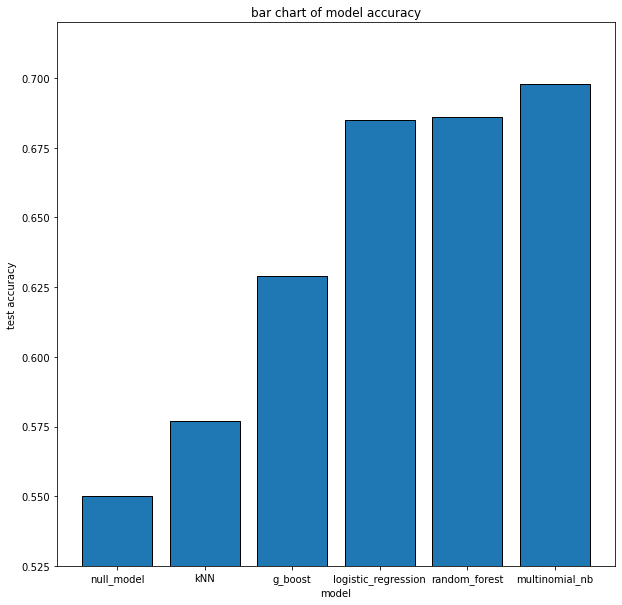

In [170]:
plt.figure(figsize = (10,10))
plt.ylim(ymin = .525, ymax = .72)
plt.title('bar chart of model accuracy')
plt.xlabel('model')
plt.ylabel('test accuracy')
plt.bar(score_df['model'], score_df['test_accuracy'], ec = 'black');

The above bar chart shows the relative accuracy of all the models that were trained in this analysis. Compared to the null model, each of the models provided an increase in test accuracy. Due to the high overlap of the NLP data between the two subreddits, kNN did by far the worst job at predicting between the "Politics" and "Conservative" subreddits. The best model was Multinomial Naive Bayes, which achieved a 69.8% accuracy rate on predictions. 

METRICS ON BEST MODEL

In [171]:
cvec_preds = cvec_nb.predict(X_test)

In [172]:
confusion_matrix(y_test,
                cvec_preds)

array([[2557, 1484],
       [1229, 3723]])

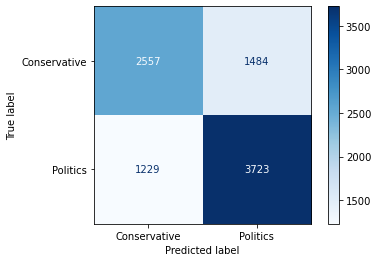

In [173]:
plot_confusion_matrix(cvec_nb, X_test, y_test, cmap='Blues', 
                      values_format='d', display_labels=['Conservative', 'Politics']);

Particularly compared to the kNN confusion matrix, the MultinomialNB model is much closer to the kind of result we were hoping to achieve, with decent accuracy and similar sensitivity and specificity. The model still made a large number of incorrect predictions, but this is to be expected based on the data.

In [175]:
recall = recall_score(y_test, preds)
recall

0.7518174474959612

In [176]:
precision = precision_score(y_test, preds)
precision

0.7149990397541771

In [181]:
roc_auc_score(y_test,
              cvec_nb.predict_proba(X_test)[:,1])

0.7599226266791237

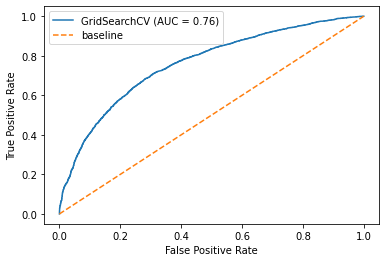

In [182]:
plot_roc_curve(cvec_nb,
               X_test,
               y_test)
plt.plot([0,1],[0,1], label = 'baseline', linestyle = '--')
plt.legend();

I would describe each of these metrics as "decent". I had not expected to achieve much predictive power at the outset of the project, so roughly 70% accuracy and a .75 ROC-AUC score surpass my expectations and seem fairly acceptable for such similar subreddits.

Ultimately, MultinomialNB performed the best on this set of data. The model achieved a .76 ROC-AUC score, which is basically right in the middle between as bad as a model can be and as good as a model can be. I was unsure that any of these models would be able to achieve any significant increase in accuracy compared to the null model due to the overlap in word choice between the two subreddits, so a near 70% accuracy in a model that has relatively low variance is satisfactory to me.

I did some modeling on the side with some of the other data included in the original dataframe (like number of comments, score, and word count) and was unable to surpass these NLP models (while some came close). Future analysis may want to look more at the numerical statistics of Reddit posts, as this would be far less computationally-expensive and likely more interpretable. It would also allow for more feature engineering, which could be extremely useful when comparing extremely-similar subreddits.